# Imports

In [248]:
### Imports ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from Data_Merger_Pipeline import DataMerger
from Data_Transformer_Pipeline import Data_Transformer

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier

# Helper Functions

In [249]:
#Helper Functions
def visualize_confusion_matrix(model, y_test, y_pred):
    mat = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(mat, square=True, annot=True, cbar=True)
    #plt.title(model.__class__.__name__)
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    
def display_scores(clf, X_test, y_test): 
    acc_score = np.mean(cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=5))
    prec_score = np.mean(cross_val_score(clf, X_test, y_test, scoring='precision', cv=5))
    rec_score = np.mean(cross_val_score(clf, X_test, y_test, scoring='recall', cv=5))
    f_score = np.mean(cross_val_score(clf, X_test, y_test, scoring='f1', cv=5))
    
    name = clf.__class__.__name__
    print('\n'+name+':')
    print('   Precision Score:', prec_score)
    print('   Recall Score:', rec_score)
    print('   F1 Score:', f_score)
    print('   Accuracy Score:', acc_score,'\n')

# Loading Data

In [250]:
### Loading Data ###
web_data_df = pd.read_csv("Data/Loaded_Data/Web_Data.csv")
keV_index = web_data_df['mass'][web_data_df['mass'].str.contains('keV') == True].index
web_data_df = web_data_df.drop(keV_index)
web_data_df.reset_index(drop=True)

github_data_df = pd.read_csv("Data/Loaded_Data/Github_Data.csv")

# Cleaning Data

In [251]:
### Merging Data ###
cols_to_keep = ['Z','N','Mass','Half Life','M']
data_merger = DataMerger(cols_to_keep)
df = data_merger.transform(web_data_df, github_data_df)[1:].reset_index(drop=True)

/Users/elliotgross/Desktop/Nuclear-Physics-ML-master/Nuclear ML/Data_Merger_Pipeline.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  web_data_df['N'] = np.floor(web_data_df['Mass']) - web_data_df['Z']


In [252]:
### Splitting Data And Target Vector ###
X = df.drop(['Half Life','M'], axis=1)
y = df['Half Life']

In [253]:
### Prepare Data ###
X_features = ['Z','N','Adj. N/P']

data_transformer = Data_Transformer(X_features='all',
                                    target_vector='Seconds', prediction_type='Binary',
                                    magnitude_threshold=2, seconds_threshold=3600,
                                    X_imputer_strat='drop', X_fill_value='None',
                                    y_imputer_strat='drop', y_fill_value='None')

prepared_X, prepared_y = data_transformer.transform(X, y)

print(prepared_X.shape, prepared_y.shape)

/Users/elliotgross/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(2728, 13) (2728,)


# Normalizing Data

In [254]:
### Normalizing X-Values ### *Put into Data Transformer Pipeline after deciding on design*
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler().fit(prepared_X)
X_norm = pd.DataFrame(norm.transform(prepared_X), columns=prepared_X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_norm,prepared_y,test_size=0.2,random_state=42) 

# Splitting Data

In [255]:
### Splitting Data ### *Clould Be done before or after transforming data*
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm,prepared_y,test_size=0.2,random_state=42)  
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.001,
                                                  #random_state=27)
    


# Creating/Traning Model

In [256]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

xgb_model = XGBClassifier(verbosity=0)


'''parameters = {'nthread':[1,2,3,4,10],
              'objective':['binary:logistic'],
              'learning_rate': [0.01],
              'max_depth': [1,2,3,5,8,10],
              'min_child_weight': [1,2,3,10,12],
              'silent': [1],
              'subsample': [0.1,0.2,0.5,0.8],
              'colsample_bytree': [0.01, 0.1, 0.2, 0.5],
              'n_estimators': [1000],
              'missing':[-999],
              'seed': [1337]}''' # For Tuning

parameters = {'nthread':[1],
              'objective':['binary:logistic'],
              'learning_rate': [0.01],
              'max_depth': [8],
              'min_child_weight': [3],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.5],
              'n_estimators': [1000],
              'missing':[-999],
              'seed': [1337]}


xgb_model = GridSearchCV(estimator=xgb_model, param_grid=parameters, n_jobs=1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='f1',
                   refit=True)

xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_train).reshape(-1,1)

print(xgb_model.best_score_)
xgb_model.best_params_

0.8490181049292984


{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 8,
 'min_child_weight': 3,
 'missing': -999,
 'n_estimators': 1000,
 'nthread': 1,
 'objective': 'binary:logistic',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.8}

In [257]:
rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'random_state': [1],
    'n_estimators': [100],
    'max_features': ['auto'],
    'max_depth' : [8],
    'criterion' :['entropy']
}

rfc_model = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='f1', cv=5)
rfc_model.fit(X_train, y_train)

predictions = rfc_model.predict(X_test).reshape(-1,1)

print(rfc_model.best_score_)
rfc_model.best_params_

0.8356228701579015


{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 100,
 'random_state': 1}

In [258]:
rfc_scores = {'accuracy':[],'precision':[],'recall':[],'f1':[],'explained_variance':[]}
xgb_scores = {'accuracy':[],'precision':[],'recall':[],'f1':[],'explained_variance':[]}

for i in range(20):
    print('Loop',str(i),'Started')
    X_train, X_test, y_train, y_test = train_test_split(X_norm,prepared_y,test_size=0.2,random_state=i*2)
    for key in rfc_scores.keys():
        rfc_scores[key].append(cross_val_score(rfc_model, X_train, y_train, cv=5, scoring=key).mean())
        xgb_scores[key].append(cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=key).mean())
    print('Loop',str(i),'Ended')

Loop 0 Started
Loop 0 Ended
Loop 1 Started
Loop 1 Ended
Loop 2 Started
Loop 2 Ended
Loop 3 Started
Loop 3 Ended
Loop 4 Started
Loop 4 Ended
Loop 5 Started
Loop 5 Ended
Loop 6 Started
Loop 6 Ended
Loop 7 Started
Loop 7 Ended
Loop 8 Started
Loop 8 Ended
Loop 9 Started
Loop 9 Ended
Loop 10 Started
Loop 10 Ended
Loop 11 Started
Loop 11 Ended
Loop 12 Started
Loop 12 Ended
Loop 13 Started
Loop 13 Ended
Loop 14 Started
Loop 14 Ended
Loop 15 Started
Loop 15 Ended
Loop 16 Started
Loop 16 Ended
Loop 17 Started
Loop 17 Ended
Loop 18 Started
Loop 18 Ended
Loop 19 Started
Loop 19 Ended


In [259]:
rfc_df = pd.DataFrame(rfc_scores)
rfc_df['Model'] = ['RFC' for i in range(rfc_df.shape[0])]
rfc_df = rfc_df.set_index(['Model', np.arange(0,rfc_df.shape[0])])

xgb_df = pd.DataFrame(xgb_scores)
xgb_df['Model'] = ['XGB' for i in range(xgb_df.shape[0])]
xgb_df = xgb_df.set_index(['Model', np.arange(0,xgb_df.shape[0])])

scores_df = pd.concat([xgb_df, rfc_df])

for scoring in scores_df.columns:
    result = scores_df.loc['RFC'][scoring].mean() - scores_df.loc['XGB'][scoring].mean()
    print('Scoring Method:', scoring)
    print('Average',scoring,'Score of 20 loops difference:',result,'\n')
    

Scoring Method: accuracy
Average accuracy Score of 20 loops difference: -0.0092798060168372 

Scoring Method: precision
Average precision Score of 20 loops difference: -0.02338383523163101 

Scoring Method: recall
Average recall Score of 20 loops difference: -0.0006837029328580213 

Scoring Method: f1
Average f1 Score of 20 loops difference: -0.012267393356009904 

Scoring Method: explained_variance
Average explained_variance Score of 20 loops difference: -0.04209906269559327 



In [260]:
#Train Model
xgb_model.fit(X_train, y_train)

#Make Predictions
xgb_predictions = xgb_model.predict(X_test).reshape(-1,1)

# Scoring


Unstable: 361 Stable: 185

Predicted Unstable: 352 Predicted Stable: 194

GridSearchCV:
   Precision Score: 0.8233338625598687
   Recall Score: 0.7675675675675675
   F1 Score: 0.7899635482811826
   Accuracy Score: 0.8662718932443703 



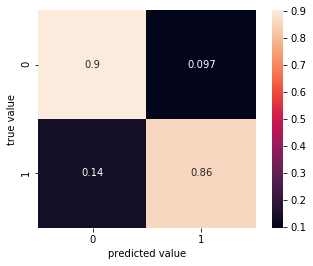

In [261]:
print('\nUnstable:', str(len(y_test[y_test == 0])),
      'Stable:',str(len(y_test[y_test == 1])))
print('\nPredicted Unstable:', str(len(xgb_predictions[xgb_predictions == 0])),
      'Predicted Stable:',str(len(xgb_predictions[xgb_predictions == 1])))

visualize_confusion_matrix(xgb_model, y_test, xgb_predictions)
display_scores(xgb_model, X_test, y_test)

#print(np.array(y_test))
#print(predictions)

In [350]:

def quick_model_prediction(model, target, m_threshold=2, s_threshold=10):
    data_transformer = Data_Transformer(X_features='all',
                                        target_vector='Seconds', prediction_type='Binary',
                                        magnitude_threshold=2, seconds_threshold=3600,
                                        X_imputer_strat='drop', X_fill_value='None',
                                        y_imputer_strat='drop', y_fill_value='None')

    prepared_X, prepared_y = data_transformer.transform(X, y)

    norm = MinMaxScaler().fit(prepared_X)
    X_norm = pd.DataFrame(norm.transform(prepared_X), columns=prepared_X.columns)

    model.fit(X_train, y_train)
    
    return model

In [351]:
#year_prediction = quick_model_prediction(xgb_model, 'Seconds', s_threshold=)

/Users/elliotgross/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     miss...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=0),
             n_jobs=1,
             param_g

In [354]:
from decimal import Decimal
z, n = [],[]
for i in range(80,130):
    for j in range(120,250):
        z.append(i)
        n.append(j)
        
test_df = pd.DataFrame({'Z':z, 'N':n})
test_df['Mass'] = test_df['N'] + test_df['Z']
test_df['Mass'] = [Decimal(test_df.loc[i,'Z']*0.00054386734)+test_df.loc[i,'Mass'] for i in range(test_df.shape[0])]

#fix mass

prepared_X_test = data_transformer.transform(test_df)

norm = MinMaxScaler().fit(prepared_X_test)
X_norm_test = pd.DataFrame(norm.transform(prepared_X_test), columns=prepared_X_test.columns)

test_predictions = xgb_model.predict(X_norm_test)
test_predictions.shape

(6500,)

Text(0, 0.5, 'Z')

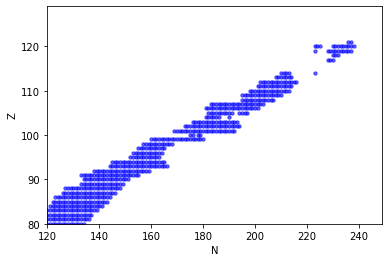

In [355]:
stable = prepared_X_test[test_predictions==1]
unstable = prepared_X_test[test_predictions==0]


plt.scatter(stable['N'], stable['Z'], color='blue', alpha=.6, s=11)
#plt.scatter(unstable['N'], unstable['Z'], color='red', alpha=.5, s=10)


plt.xlim(test_df['N'].min(), test_df['N'].max())
plt.ylim(test_df['Z'].min(), test_df['Z'].max())

plt.xlabel('N')
plt.ylabel('Z')

In [342]:
from decimal import Decimal
z, n = [],[]
for i in range(1,int(prepared_X['Z'].max())):
    for j in range(1,int(prepared_X['N'].max())):
        z.append(i)
        n.append(j)
        
test_df = pd.DataFrame({'Z':z, 'N':n})
test_df['Mass'] = test_df['N'] + test_df['Z']
test_df['Mass'] = [Decimal(test_df.loc[i,'Z']*0.00054386734)+test_df.loc[i,'Mass'] for i in range(test_df.shape[0])]

#fix mass

prepared_X_test = data_transformer.transform(test_df)

norm = MinMaxScaler().fit(prepared_X_test)
X_norm_test = pd.DataFrame(norm.transform(prepared_X_test), columns=prepared_X_test.columns)

test_predictions = xgb_model.predict(X_norm_test)
test_predictions.shape

(20592,)

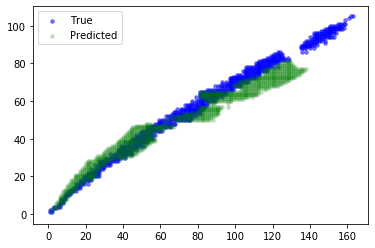

In [347]:
true_stable = prepared_X[prepared_y==1]
plt.scatter(true_stable['N'], true_stable['Z'], color='blue', alpha=.5, s=12, label='True')

predicted_stable = prepared_X_test[test_predictions==1]
plt.scatter(predicted_stable['N'], predicted_stable['Z'], color='green', alpha=.2, s=12, label='Predicted')

plt.legend()